In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import time
import GPflow
import numpy as np
import time
import cPickle as pickle
import assigngp_dense
import VBHelperFunctions
import mouseQPCRModelSelection

In [2]:
pt,Yall = mouseQPCRModelSelection.LoadMouseQPCRData(subsetSelection=0)

Loaded GPLVM data/guo_ssData.p with nrowsXncols = (437, 2).
LoadMouseQPCRData output


In [3]:
import pods
g = 'Id2'
print  'Load gene expression'
data = pods.datasets.singlecell()
genes = data['Y']  
Y = genes[g].values[:,None]    
t0=time.time()  
N = Y.shape[0]
labels = data['labels']
stageCell = np.zeros(N)
stageN = np.zeros(N)
for i,l in enumerate(labels):
    stageCell[i] = int(l[:2])
    stageN[i] = np.log2(stageCell[i]) + 1
    
#pt = stageN

Load gene expression


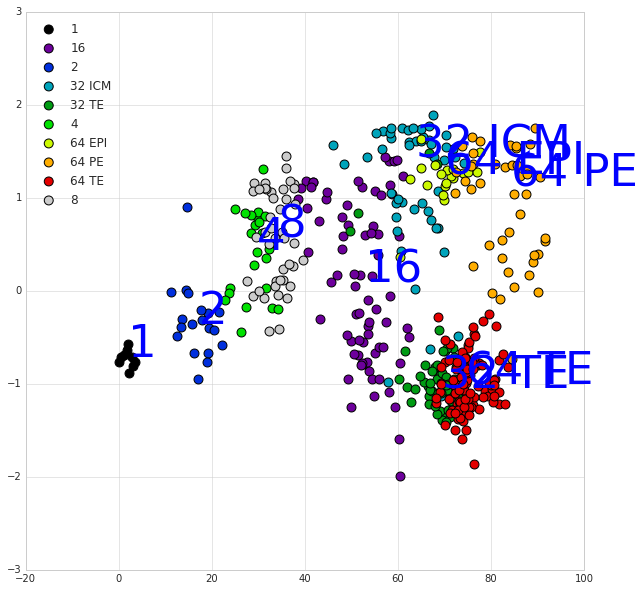

In [4]:
def plotGene(t,g,labels):
    import matplotlib.cm as cm
    labelLegend = np.unique(labels)
    with plt.style.context('seaborn-whitegrid'):
        colors = cm.spectral(np.linspace(0, 1, len(labelLegend)))
        plt.figure(figsize=(10, 10))
        for lab,c in zip(labelLegend,colors):
            y1 = t[labels == lab]
            y2 = g[labels == lab]
            plt.scatter(y1,y2,label=lab, c=c,s=80)
            plt.text(np.median(y1),np.median(y2),lab, fontsize=45, color='blue')
        plt.legend(loc='upper left')
plotGene(pt, Y, labels)

In [22]:
# Do Bayesin GPLVM on capture times
Yraw= data['Y'].values
X = np.expand_dims(stageN,1)
X_variance = np.ones_like(X)
print X_variance.shape
import GPy
mgplvm = GPy.models.BayesianGPLVM(Yraw, 1, X=X, X_variance=X_variance, Z=np.expand_dims(np.unique(stageN),1))
mgplvm.Z.fix()
mgplvm.likelihood.fix(Yraw.std()/100)
mgplvm.optimize(messages=1, max_iters=200)
mgplvm.likelihood.unfix()
mgplvm.optimize(messages=1)



(437, 1)


In [21]:
np.expand_dims(np.unique(stageN),1).shape

(7, 1)

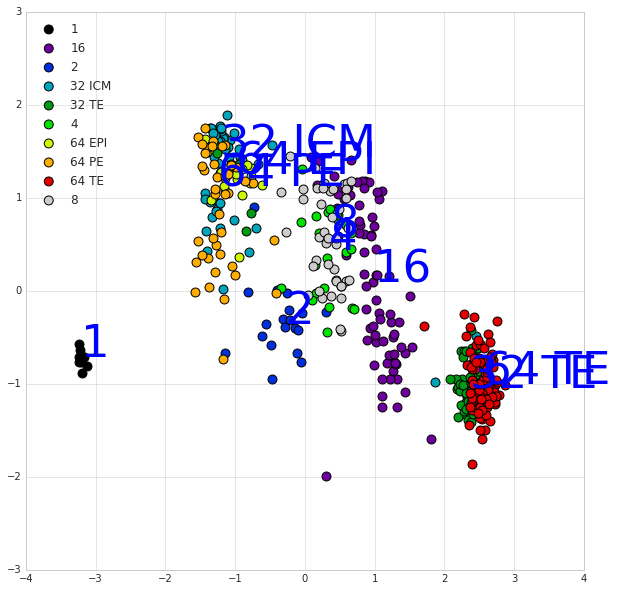

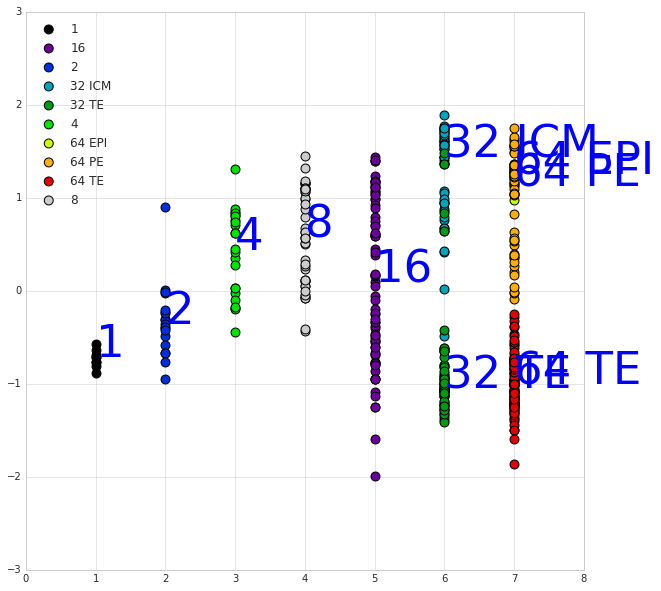

In [23]:
#plotGene(pt, genes['Id2'].values, labels) # pseudotime by Max
plotGene(mgplvm.X.mean.values, genes['Id2'].values, labels) # pseudotime by 1-D GPLVM
plotGene(stageN, genes['Id2'].values, labels) # Capture time

array([[ 0.32846008],
       [ 0.33261746],
       [ 0.31450079],
       [ 0.31901968],
       [ 0.32616428],
       [ 0.31439785],
       [ 0.31287376],
       [ 0.29435472],
       [ 0.30403732],
       [-1.61598568],
       [-1.57909819],
       [-1.53142783],
       [-1.54599395],
       [-1.61976676],
       [-1.57924348],
       [-1.57441506],
       [-1.5922397 ],
       [-1.5751612 ],
       [-1.47591869],
       [-1.53261001],
       [-1.60543451],
       [-1.62215277],
       [-1.55551819],
       [-1.58944985],
       [-1.48887164],
       [-1.50235968],
       [-1.54435191],
       [-1.53508833],
       [-1.39751607],
       [-1.38885042],
       [-1.40471062],
       [-1.3809603 ],
       [-1.37942156],
       [-1.42276066],
       [-1.32513009],
       [-1.36282535],
       [-1.35610741],
       [-1.31928846],
       [-1.27638467],
       [-1.31105662],
       [-1.29781639],
       [-1.30937302],
       [-1.23634963],
       [-1.36105093],
       [-1.44366957],
       [-1

In [ ]:
from GPclust import OMGP
m = OMGP(pt[:,None], Y, K=2, variance=0.01, prior_Z='DP') # use a truncated DP with K=2
m.rbf.lengthscale = 65
m.rbf_1.lengthscale = 65
m.optimize(step_length=0.01, maxiter=20)
fig=plt.figure(figsize=(10,10))
m.plot()

In [ ]:
m.optimize(step_length=0.01, maxiter=100)
m.plot()

In [ ]:
m.plot_probs()

In [ ]:
m

# VB Branching code

In [ ]:
import BranchingTree as bt
import branch_kernParamGPflow as bk
def InitModels(pt, XExpanded, Y):
    # code that's a bit crappy - we dont need this
    tree = bt.BinaryBranchingTree(0,90,fDebug=False) # set to true to print debug messages
    tree.add(None,1,10) # single branching point
    (fm, _) = tree.GetFunctionBranchTensor()
    #KbranchVB = bk.BranchKernelParam(GPflow.kernels.RBF(1), fm, BvInitial=np.ones((1,1))) + GPflow.kernels.White(1) 
    KbranchVB = bk.BranchKernelParam(GPflow.kernels.RBF(1), fm, BvInitial=np.ones((1,1))) + GPflow.kernels.White(1) + GPflow.kernels.Linear(1) + GPflow.kernels.Constant(1) # other copy of kernel
    KbranchVB.branchkernelparam.Bv.fixed = True
    mV = assigngp_dense.AssignGP(pt, XExpanded, Y, KbranchVB)
    mV.kern.white.variance = 1e-6
    mV.kern.white.variance.fixed = True
    mV._compile() # creates objective function
    return mV

In [ ]:
phiInitial, phiInitial_invSoftmax, XExpanded = VBHelperFunctions.InitialisePhiFromOMGP(None, phiOMGP=m.phi, b=0, Y=Y,pt=pt)   
mV = InitModels(pt,XExpanded,Y) # also do gene by gene

In [ ]:
mV

In [ ]:
m

In [ ]:
# Initialise all model parameters using the OMGP model
# Note that the OMGP model has different kernel hyperparameters for each latent function whereas the branching model
# has one common set.
mV.logPhi = phiInitial_invSoftmax # initialise allocations from OMGP
mV.likelihood.variance = m.variance.values[0]
# set lengthscale to maximum
mV.kern.branchkernelparam.kern.lengthscales = np.max(np.array([m.rbf.lengthscale.values, m.rbf_1.lengthscale.values]))
# set process variance to average
mV.kern.branchkernelparam.kern.variance = np.mean(np.array([m.rbf.variance.values, m.rbf_1.variance.values]))
mV

In [ ]:
def FlattenPhi(mV):
    # return flattened and rounded Phi i.e. N X 3
    phiFlattened = np.zeros((mV.Y.shape[0],3)) # only single branching point
    Phi = np.round(np.exp(mV.logPhi._array),decimals=4)
    f=2 # which function to plot phi against - can be 1,2 or 3
    iterC=0
    for i,p in enumerate(mV.t):
        phiFlattened[i,:] = Phi[i,iterC:iterC+3] 
        iterC+=3
    return phiFlattened
Phi=FlattenPhi(mV)

In [ ]:
def plotVBCode(mV,figsizeIn=(20,10),lw=3.,fs=10):
    from matplotlib import cm
    D = mV.Y.shape[0]
    fig=plt.figure(figsize=figsizeIn)
    B=mV.kern.branchkernelparam.Bv._array.flatten()
    assert B.size == 1, 'Code limited to one branch point, got ' + str(B.shape)
    pt = mV.t
    l = np.min(pt)
    u = np.max(pt)
    d = 0 # constraint code to be 1D for now
    for f in range(1, 4):
        if(f == 1):
            ttest = np.linspace(l, B, 100)[:, None]  # root
        else:
            ttest = np.linspace(B, u, 100)[:, None]
        Xtest = np.hstack((ttest, ttest*0+f))
        mu, var = mV.predict_f(Xtest)
        assert np.all(np.isfinite(mu)), 'All elements should be finite but are ' + str(mu)
        assert np.all(np.isfinite(var)), 'All elements should be finite but are ' + str(var)
        mean, = plt.plot(ttest, mu[:, d], linewidth=lw)
        col = mean.get_color()
        plt.plot(ttest.flatten(), mu[:, d] + 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
        plt.plot(ttest, mu[:, d] - 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)

    v = plt.axis()
    plt.plot([B, B], v[-2:], '-m',linewidth=lw)
    
    # could also plot phi
    Phi=FlattenPhi(mV)
    gp_num = 1 # can be 0,1,2 
    plt.scatter(pt, mV.Y[:,d], c=Phi[:, gp_num], vmin=0., vmax=1, s=40)
    plt.colorbar(label='GP {} assignment probability'.format(gp_num))


# Bayesian optimisation
1. Use GPyOpt to learn branching point and kernel hyperparameters.
1. set fixed=False for all parameters except for Phi.fixed=True
1. It's still beneficial to use *VB code* rather than *Jings model* since we integrate out (approximately using VB bound) uncertainty in allocation (Phi).
1. Store all intermediate values visited by GPyOpt?
1. Use Matern 3/2 or 5/2 for both OMGP and our model. Actually different kernels for OMGP and our can make sense as outputs different (potentially)?
1. Effect of Phi on inference of branching point?
1. add assert in VB code that before branching point, allocations probs==1 for 1st function.


In [ ]:
import GPyOpt

In [ ]:
# Objective function
class objectiveBAndK:
    def __init__(self, Binit):
        mV.kern.branchkernelparam.Bv.fixed = False # we wont optimize so this is fine
        mV.logPhi.fixed = False # allocations not fixed for GPyOpt because we update them for each branch point

        mV.likelihood.variance.fixed = False # all kernel parameters optimised
        mV.kern.branchkernelparam.kern.lengthscales.fixed = False
        mV.kern.branchkernelparam.kern.variance.fixed = False

        # initial branch point
        mV.kern.branchkernelparam.Bv = Binit
        VBHelperFunctions.InitialisePhiFromOMGP(mV, phiOMGP=m.phi, b=Binit, Y=Y, pt=pt)  
        # Initialise all model parameters using the OMGP model 
        mV.likelihood.variance = m.variance.values[0]
        mV.kern.branchkernelparam.kern.lengthscales = np.max(np.array([m.rbf.lengthscale.values, m.rbf_1.lengthscale.values]))
        mV.kern.branchkernelparam.kern.variance = np.mean(np.array([m.rbf.variance.values, m.rbf_1.variance.values]))
        mV._compile()

    def f(self, theta):
        # theta is nxp array, return nx1
        n=theta.shape[0]
        VBboundarray = np.ones((n,1))
        for i in range(n):
            mV.kern.branchkernelparam.Bv = theta[i,0]
            VBHelperFunctions.InitialisePhiFromOMGP(mV, phiOMGP=m.phi, b=theta[i,0], Y=Y, pt=pt)  
            mV.likelihood.variance = theta[i,1]
            mV.kern.branchkernelparam.kern.lengthscales = theta[i,2]
            mV.kern.branchkernelparam.kern.variance = theta[i,3]
            mV.kern.linear.variance = theta[i,4]
            mV.kern.constant.variance = theta[i,5]
            
            VBboundarray[i] = -mV.compute_log_likelihood() # we wish to minimize!
            print 'objectiveB B=%.0f likvar=%.0f len=%.0f var=%.0f VB=%.0f'%(theta[i,0], theta[i,1], theta[i,2], theta[i,3], VBboundarray[i] )
        return VBboundarray

In [ ]:
# try optimisation
l = pt.min() + 1
u = pt.max() - 1
print l,u
# We need constraints on there parameters
# B = [l,u] 
# lik.variance > 0
# kern.lengthscale, variance > 0

# --- Optimize both B and K
myobj = objectiveBAndK(np.ones((1,1))*(l+u)/2) # pass in initial point - start at mid-point
eps = 1e-5
#bounds = [(l,u),(eps,3*Y.var()), (eps,pt.max()), (eps,3*Y.var())]  # B, lik var, len, var

bounds = [(l,u),(eps,3*Y.var()), (eps,pt.max()), (eps,3*Y.var()), [0.1,5], [0.1,5]]  # B, lik var, len, var, lin var, c var

BOobj = GPyOpt.methods.BayesianOptimization(f=myobj.f,  # function to optimize       
                                            bounds=bounds)              # normalized y                       
t0=time.time()
max_iter = 20 
import multiprocessing
n_cores = multiprocessing.cpu_count()

BOobj.run_optimization(max_iter,                             # Number of iterations
                       acqu_optimize_method = 'fast_random',        # method to optimize the acq. function
                       acqu_optimize_restarts = 30,
                       batch_method='lp',
                       n_inbatch = n_cores,                        # size of the collected batches (= number of cores)
                       eps = 1e-6)                                # secondary stop criteria (apart from the number of iterations) 

print 'GPyOpt took %g secs ' %(time.time()-t0)

In [ ]:
print 'Solution found by BO'
print BOobj.x_opt
print BOobj.fx_opt

# Can explicitly check computation using myobj.f(np.ones((1,1))*16.834)
# should add assert that Phi before branching point is 1 everywhere!

In [ ]:
# plot best solution
mV.kern.branchkernelparam.Bv = BOobj.x_opt[0]
VBHelperFunctions.InitialisePhiFromOMGP(mV, phiOMGP=m.phi, b=BOobj.x_opt[0],Y=Y,pt=pt)   
mV.likelihood.variance = BOobj.x_opt[1]
mV.kern.branchkernelparam.kern.lengthscales = BOobj.x_opt[2]
mV.kern.branchkernelparam.kern.variance = BOobj.x_opt[3]
print 'Bound got %.2f should be %.2f'%(-mV.compute_log_likelihood(), BOobj.fx_opt)
plotVBCode(mV)
mV

In [ ]:
def plotVBCode(mV,figsizeIn=(20,10),lw=3.,fs=10,labels=None, fPlotPhi=True):
    import matplotlib.cm as cm
    from matplotlib import cm
    D = mV.Y.shape[0]
    fig=plt.figure(figsize=figsizeIn)
    B=mV.kern.branchkernelparam.Bv._array.flatten()
    assert B.size == 1, 'Code limited to one branch point, got ' + str(B.shape)
    pt = mV.t
    l = np.min(pt)
    u = np.max(pt)
    d = 0 # constraint code to be 1D for now
    for f in range(1, 4):
        if(f == 1):
            ttest = np.linspace(l, B, 100)[:, None]  # root
        else:
            ttest = np.linspace(B, u, 100)[:, None]
        Xtest = np.hstack((ttest, ttest*0+f))
        mu, var = mV.predict_f(Xtest)
        assert np.all(np.isfinite(mu)), 'All elements should be finite but are ' + str(mu)
        assert np.all(np.isfinite(var)), 'All elements should be finite but are ' + str(var)
        mean, = plt.plot(ttest, mu[:, d], linewidth=lw)
        col = mean.get_color()
        #plt.plot(ttest.flatten(), mu[:, d] + 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)
        #plt.plot(ttest, mu[:, d] - 2*np.sqrt(var.flatten()), '--', color=col, linewidth=lw)

    v = plt.axis()
    plt.plot([B, B], v[-2:], '-m',linewidth=lw)
    
    # Plot Phi or labels
    if(fPlotPhi):
        Phi=FlattenPhi(mV)
        gp_num = 1 # can be 0,1,2 
        plt.scatter(pt, mV.Y[:,d], c=Phi[:, gp_num], vmin=0., vmax=1, s=40)
        plt.colorbar(label='GP {} assignment probability'.format(gp_num))
    elif(labels is not None):
        # plot labels
        labelLegend = np.unique(labels)
        with plt.style.context('seaborn-whitegrid'):
            colors = cm.spectral(np.linspace(0, 1, len(labelLegend)))
            for lab,c in zip(labelLegend,colors):
                y1 = pt[labels == lab]
                y2 = Y[labels == lab]
                plt.scatter(y1,y2,label=lab, c=c,s=80)
                plt.text(np.median(y1),np.median(y2),lab, fontsize=45, color='blue')
            plt.legend(loc='upper left')
plotVBCode(mV,labels=labels,fPlotPhi=False)